In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

import Hawkes as hk
from scipy.stats import norm

## 1. Simulation.
- Write your own function that simulates one path of a Hawkes process with a generic decreasing kernel using the thinning algorithm.


        Input: constant baseline intensity, kernel function, horizon.
        
        Output: time series of events.

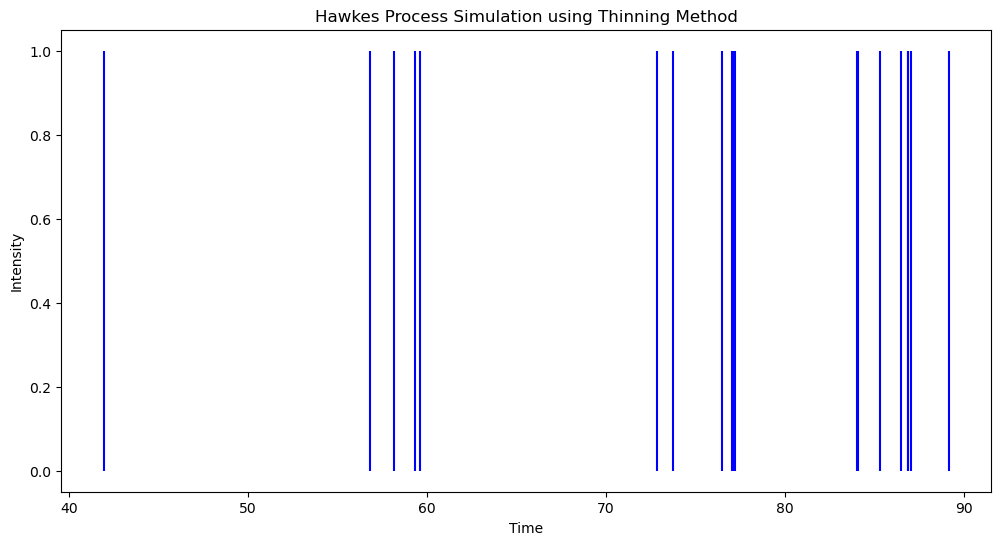

In [2]:
# Hawkes process parameters
mu = 0.1  # Baseline intensity
alpha = 0.5  # Excitation parameter
beta = 1.0  # Decay rate

# Simulation parameters
t_end = 100  # End time for the simulation


def intensity(t, history, mu, alpha, beta):
    return mu + np.sum(alpha * np.exp(-beta * (t - history[history <= t])))

def simulate_hawkes_process(mu, alpha, beta, t_end):
    history = []
    t = 0
    
    max_intensity = mu  # Upper bound for the intensity function (for thinning)

    while t < t_end:
        u = np.random.uniform()
        t += -np.log(u) / max_intensity  # Generate a candidate event using the upper bound

        if t >= t_end:
            break

        D = np.random.uniform()
        if D <= intensity(t, np.array(history), mu, alpha, beta) / max_intensity :  # Accept or reject the candidate
            history.append(t)
            
        max_intensity = intensity(t, np.array(history), mu, alpha, beta)

    return np.array(history)

# Simulate the Hawkes process
history = simulate_hawkes_process(mu, alpha, beta, t_end)

# Plot the result
plt.figure(figsize=(12, 6))
plt.vlines(history, 0, 1, color='blue')
plt.title("Hawkes Process Simulation using Thinning Method")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.show()

## 2. Sanity check.

- Choose some values to define a stable Hawkes process with a single exponential kernel. Simulate a realization of this Hawkes process using your own code.

- Check that the order of magnitude of the number of events in the sample is the one expected.


In [3]:
def sanity_check(mu, alpha, beta, t_end,N):
    
    avg_n_events = np.mean( [len(simulate_hawkes_process(mu, alpha, beta, t_end)) for i in range(N)])
    
    print(f"Expected average number of events: {t_end*mu/(1-alpha/beta)}")
    print(f"Actual average number of events: {avg_n_events}")


# Hawkes process parameters
mu = 0.1  # Baseline intensity
alpha = 0.5  # Excitation parameter
beta = 1.0  # Decay rate

# Simulation parameters
t_end = 100  # End time for the simulation

N = 100 # number of simulation
    
sanity_check(mu, alpha, beta, t_end,N)

Expected average number of events: 20.0
Actual average number of events: 18.57


## 3. Convergence of MLE estimates.
- Choose some values to define a stable Hawkes process with a single exponential kernel. For a given T, simulate multiple (e.g., 50) realizations of this Hawkes process using your own code. Using the external library, show that for each parameter the MLE estimates converge towards the true values when T increases. For each parameter estimate the order of convergence in T. Comment.


In [4]:
np.random.seed(42)
# Hawkes process parameters
mu = 0.1  # Baseline intensity
alpha = 0.5  # Excitation parameter
beta = 1.0  # Decay rate

# Simulation parameters

T = np.linspace(200,1000,100,dtype=int)  # End time for the simulation

n_sim = 50
parameters = []

for t_end in T:
    parameters.append([])
    for i in range(n_sim):
        events = simulate_hawkes_process(mu, alpha, beta, t_end)
        model = hk.estimator().set_kernel('exp').set_baseline('const')
        model.fit(events,[0,t_end])
        
        parameters[-1].append(list(model.parameter.values()))

parameters = np.array(parameters)

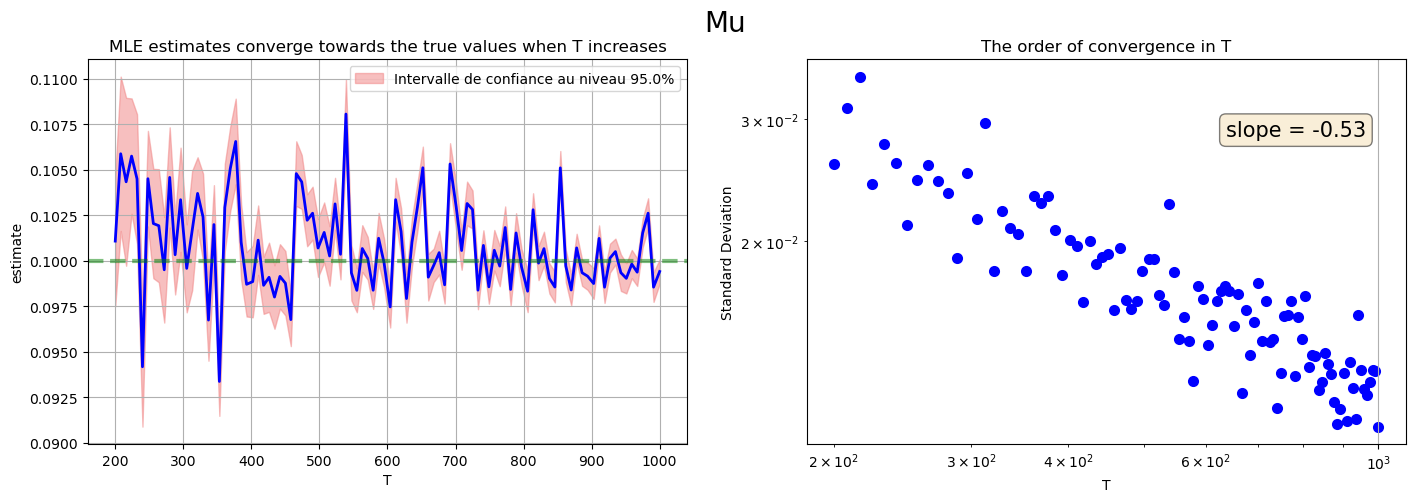

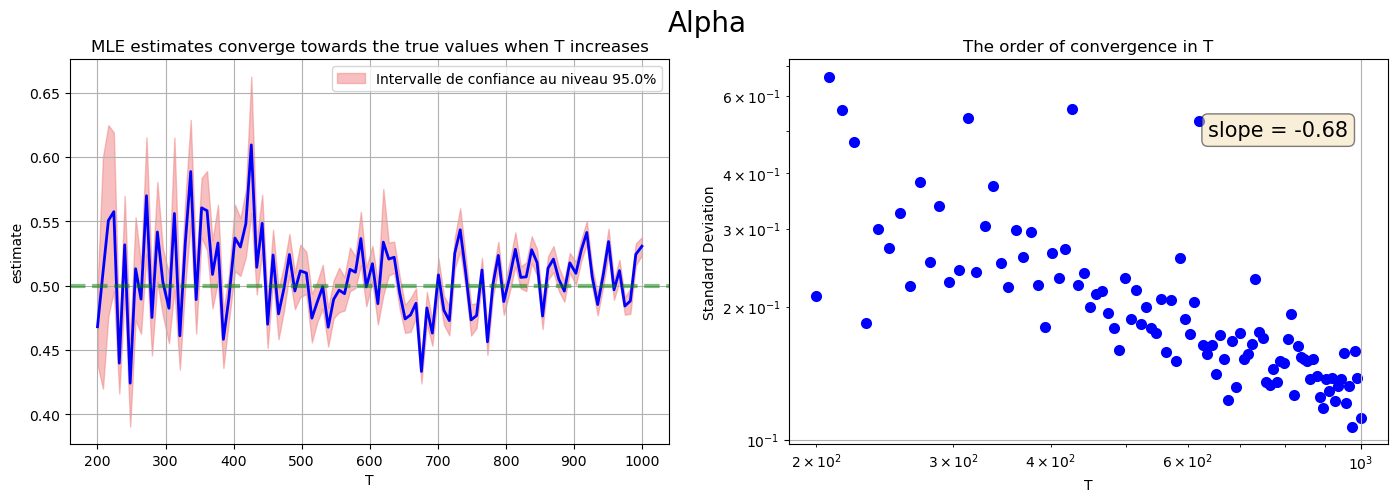

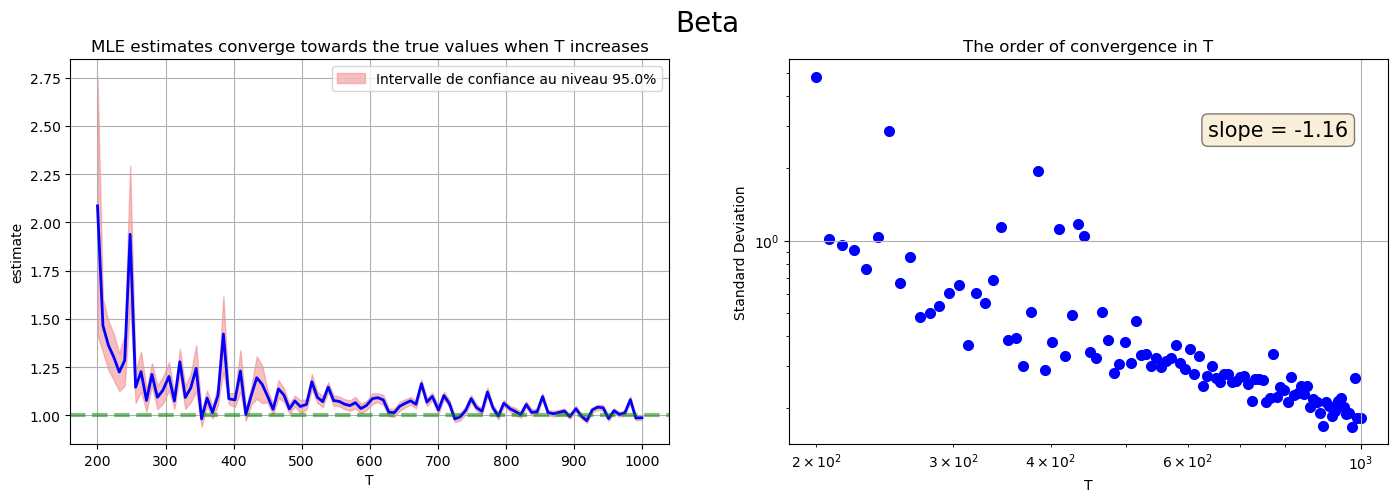

In [5]:
def show_conv(T,l,parameter,title):
    IC = 0.95
    q_alpha = norm.ppf(1 - (1-IC)/2)
    
    x_mean = l.mean(axis=1)
    x_std = np.std(l,axis=1)
       
    borne = q_alpha*x_std/np.sqrt(T)
    conf_min = x_mean - borne
    conf_max = x_mean + borne
    
    ## figure
    fig, axs = plt.subplots(1,2, figsize=(17, 5))
    fig.suptitle(title,fontsize = 20)
    
    axs[0].set_title('MLE estimates converge towards the true values when T increases')
    axs[0].plot(T, x_mean, color="blue", linewidth = 2)
    axs[0].axhline(y=parameter, xmin=0, xmax=1, color='green', alpha=0.5, linestyle='--', linewidth=3)
    axs[0].fill_between(T, conf_min, conf_max, color="lightcoral", alpha=0.5, label="Intervalle de confiance au niveau " + str(0.95 * 100) + "%")
    axs[0].set_xlabel('T')
    axs[0].set_ylabel('estimate')
    axs[0].grid()
    axs[0].legend(fontsize=10)
    
    axs[1].set_title('The order of convergence in T')
    axs[1].scatter(T, x_std, color="blue", linewidth = 2)
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].grid()
    axs[1].set_xlabel('T')
    axs[1].set_ylabel('Standard Deviation')
    
    # fit a line to the plot using numpy's polyfit function
    coefficients = np.polyfit(np.log(T), np.log(x_std), 1)
    slope,b = coefficients[0],coefficients[0]
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = f'slope = {round(slope,2)}'

    axs[1].text(0.7, 0.8,textstr,fontsize=15, transform=axs[1].transAxes,bbox=props)
    

mu_mle = parameters[:,:,0]

beta_mle = parameters[:,:,2]

alpha_mle = parameters[:,:,1]/beta_mle ## Dans la librairie : kernel  = alpha * beta *exp(-beta*tau) (externe

show_conv(T,mu_mle,mu,'Mu')
show_conv(T,alpha_mle,alpha,'Alpha')
show_conv(T,beta_mle,beta,'Beta')
plt.show()


## Commentaire:


On observe bien la convergence de l'estimateur MLE vers les valeurs réelles. Pour un petit horizon, l'incertitude est très élevée. Néamoins, l'erreur diminue rapidement dès qu on augmente l'horizon.


le logarithme de l'écart-type de l'estimateur $MLE$ décroit linéairement avec le logarithme de l'horizon (T). 

Théoriquement, cette évolution linéaire est de pente $-\frac{1}{2}$. En effet, l'estimateur est asymptotiquement normal: $
\sqrt{T}\left(\hat{\theta}_T-\theta^*\right) \rightarrow \mathcal{N}\left(0, I^{-1}\left(\theta^*\right)\right)
$

tel que MLE estimator $\hat{\theta}_T=(\hat{\lambda}_0, \hat{\alpha}_j, \hat{\beta}_j)$ et  $I(\theta)=\left(\mathrm{E}\left[\frac{1}{\lambda} \frac{\partial \lambda}{\partial \theta_i} \frac{\partial \lambda}{\partial \theta_j}\right]\right)_{i, j}$ 

Par conséquent si $\sigma_T = \frac{b}{\sqrt({T}}$ alors $log(\sigma_T) = log(b) - \frac{1}{2}log(T)$

Sachant que l'estimateur est asympotiquement normal (et non pas normal), les pentes dans les graphes de mu et alpha sont relativement proches de 0.5. Alors que la pente de beta est à peu près le double de 0.5.

## 4. Goodness-of-fit.
Write your own function that compute the integral of a Hawkes intensity with a single exponential kernel between events in a sample.
- Input: constant baseline intensity, kernel function, horizon of the sample and sample.
- Output: series of intensities integrated on durations.

Compute the QQ-plot of the integrated intensities of the fitted process versus the
theoretical exponential distribution. Comment.


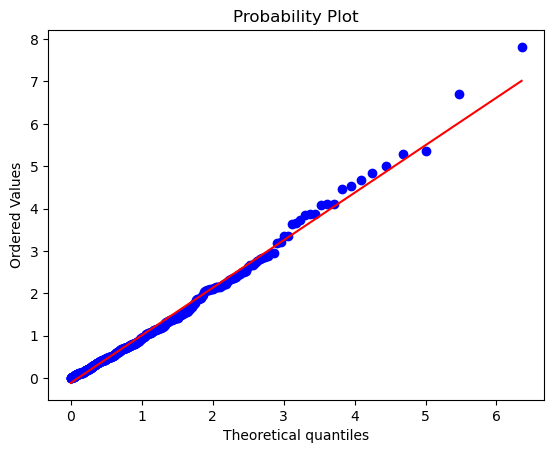

In [6]:
import scipy.stats as stats

def exponential_kernel(alpha, beta, t):
    return alpha * np.exp(-beta * t)

def integrated_hawkes_intensity(baseline, alpha, beta, horizon, sample):
    
    integrated_intensities = [baseline*sample[0]]
    
    A = 1
    
    for i in range(1,len(sample)) :

        dt = sample[i] - sample[i-1]
        lambd = baseline*dt + alpha/beta * (1-np.exp(-beta*dt))*A

        A = 1 + np.exp(-beta*dt)*A
            
        integrated_intensities.append(lambd)

    return integrated_intensities

def compute_qq_plot(integrated_intensities):

    stats.probplot(integrated_intensities, dist="expon",plot=plt)
    plt.show()




# Example usage
baseline = 0.2
alpha = 0.5
beta = 1.0
horizon =1000


sample = simulate_hawkes_process(baseline, alpha, beta, horizon)




integrated_intensities = integrated_hawkes_intensity(baseline, alpha, beta, horizon, sample)
compute_qq_plot(integrated_intensities)

#### Proposition (intensité intégrée entre les moments des événements)
- Soit $\tilde{N}$ un processus de Poisson non homogène avec une intensité $t \mapsto \lambda(t)$. Soit $\left(t_i\right)_{i \geq 1}$ les instants aléatoires des événements comptés. Alors les variables aléatoires $\left(\Lambda\left(t_i\right)-\Lambda\left(t_{i-1}\right)\right)_{i \geq 2} = \int_{\tilde{t}_{i-1}}^{\tilde{t}_i} \lambda_s d s$ sont des variables aléatoires i.i.d., exponentiellement distribuées avec le paramètre 1 .

- Pour un processus de Hawkes unidimensionnel avec un noyau exponentiel :
$$
\begin{aligned}
\Lambda\left(t_{i-1}, t_i\right)= & \int_{t_{i-1}}^{t_i} \lambda_0(s) d s + \frac{\alpha}{\beta}\left(1-e^{-\beta\left(t_i-t_{i-1}\right)}\right) A(i-1)
\end{aligned}
$$
tel que $A(1)=1$ et
$
A(i-1)=1+e^{-\beta_j\left(t_{i-1}-t_{i-2}\right)} A(i-2) .
$

Dans le grpahe ci dessus, les valeurs des deux échantillons (intensité intégrés et variable de loi exponentielle de paramètre 1) sont réparties de manière similaire et que les échantillons suivent probablement la même distribution. les points sont alignés sur la ligne diagonale, cela suggère que les deux échantillons ont une distribution de probabilité similaire. Ce qui confirme les équations ci dessus

## 5. Computational time.
Choose some values to define a stable Hawkes process with a single exponential kernel. Compare the average time needed for the simulation of one realization on [0,T] using your own code and using the external library, as a function of
T. Comment.


In [7]:
def external_simulate(mu, alpha, beta, t_end):
    para = {'mu':mu, 'alpha':alpha*beta, 'beta':beta}
    itv = [0,t_end]
    model = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
    
    return model.simulate(itv)

In [8]:
# defining a stable Hawkes process
mu = 0.2
alpha = 0.5
beta = 1.0


T =np.linspace(10,1000,50,dtype=int)


internal = []
external = []

n_runs = 100

for horizon in T:
    ## external library
    external_time = timeit.Timer('external_simulate(mu, alpha, beta, t_end)',
                                 globals = {'external_simulate':external_simulate,'mu':mu,'alpha':alpha,
                                            'beta':beta,'t_end':horizon})
    external.append(external_time.timeit(n_runs)/n_runs)
    
    ## my own code 
    internal_time = timeit.Timer('simulate_hawkes_process(mu, alpha, beta, t_end)',
                                 globals = {'simulate_hawkes_process':simulate_hawkes_process,'mu':mu,'alpha':alpha,
                                            'beta':beta,'t_end':horizon})
    internal.append(internal_time.timeit(n_runs)/n_runs)

Text(0.05, 0.65, 'slope 2 = 0.89')

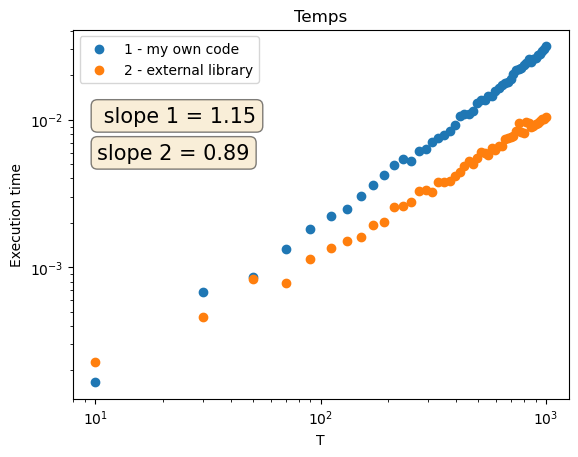

In [9]:
fig,ax =  plt.subplots(1,1)
ax.scatter(T,internal,label='1 - my own code')
ax.scatter(T,external,label='2 - external library')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Execution time')
ax.set_title('Temps')

# fit a line to the plot using numpy's polyfit function

coefficients = np.polyfit(np.log(T), np.log(internal), 1)

slope,b = coefficients[0],coefficients[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = f' slope 1 = {round(slope,2)}'
ax.text(0.05, 0.75,textstr,fontsize=15, transform=ax.transAxes,bbox=props)


coefficients = np.polyfit(np.log(T), np.log(external), 1)

slope,b = coefficients[0],coefficients[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
textstr = f'slope 2 = {round(slope,2)}'
ax.text(0.05, 0.65,textstr,fontsize=15, transform=ax.transAxes,bbox=props)

### Commentaire :
La complexité temporelle de ce code est difficile à déterminer avec précision car elle dépend du comportement spécifique du processus de Hawkes simulé, qui dépend à son tour des paramètres mu, alpha, beta et t_end. Toutefois, nous pouvons tenter d'analyser la complexité temporelle du code en fonction du nombre d'événements générés.

Dans le pire des cas, la boucle while de la fonction simulate_hawkes_process s'exécutera pendant un nombre d'itérations proportionnel au nombre d'événements générés. Chaque itération de la boucle contient un appel à la fonction intensity, qui a une complexité temporelle de O(len(history)). Puisque len(history) augmente avec le nombre d'événements, la complexité temporelle de la boucle while peut être estimée à $O(N^2)$, où $N$ est le nombre d'événements générés.

N est égale en moyenne à $\frac{T.\mu}{1-\frac{\alpha}{\beta}}$. Donc on attendra une fonction quadratique du temps d'éxucution en fonction de l'horizon. Cependant, on observe une pente dans dans une echelle logaritmique de valeur 1.09 à la place de 2.

la librairie hawkes potentiellement utliserait la version rapide des noyau exponentiels qui est en comlexité linéaire en fonction du nombre des évenements génerés. De toute façon, l'implémentation de la librairie hawkes est plus rapide que la notre.


## 6. Optimized simulation (optional).
- Write a Hawkes simulator via thinning that is specifically designed for a single exponential kernel. Compare its computational cost with the one of your code in Question 1. Comment.


In [12]:
class kernel_exp():
    def __init__(self,mu,alpha,beta):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        
        self.R = 0
        self.t = 0
        
    def event(self,t):
        
        self.R = 1 + np.exp(-self.beta*(t - self.t))*(self.R)
        
        self.t = t
        
      
    def intensity(self,t):
        
        return self.mu + self.alpha * np.exp(-self.beta * (t - self.t))*self.R
        
        

def simulate_hawkes_process_fast(mu, alpha, beta, t_end):
    history = []
    t = 0
    kernel = kernel_exp(mu,alpha,beta)
    
    max_intensity = mu  # Upper bound for the intensity function (for thinning)

    while t < t_end:
        
        u = np.random.uniform()
        step = -np.log(u) / max_intensity  # Generate a candidate event using the upper bound
        t += step

        if t >= t_end:
            break

        D = np.random.uniform()
        if D <= kernel.intensity(t) / max_intensity :  # Accept or reject the candidate
            history.append(t)
            kernel.event(t)

        max_intensity = kernel.intensity(t)

    return np.array(history)

# Hawkes process parameters
mu = 0.1  # Baseline intensity
alpha = 0.5  # Excitation parameter
beta = 1.0  # Decay rate
t_end = 100  # End time for the simulation
#number of simulations
N = 100

def sanity_check(mu, alpha, beta, t_end,N):
    
    avg_n_events = np.mean( [len(simulate_hawkes_process_fast(mu, alpha, beta, t_end)) for i in range(N)])
    
    print(f"Expected average number of events: {t_end*mu/(1-alpha/beta)}")
    print(f"Actual average number of events: {avg_n_events}")
    
sanity_check(mu, alpha, beta, t_end,N)

Expected average number of events: 20.0
Actual average number of events: 20.21


Text(0.5, 1.0, 'Temps')

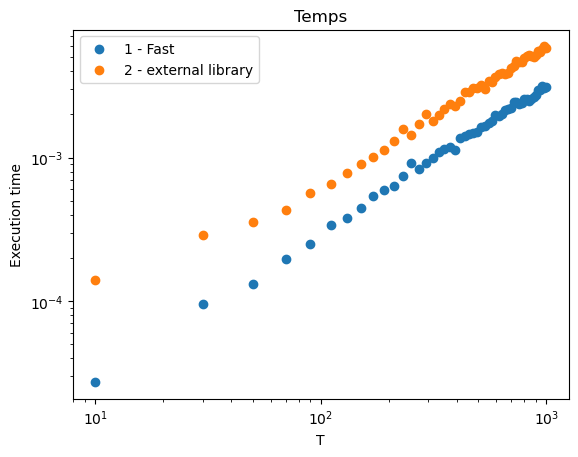

In [13]:
# defining a stable Hawkes process
baseline = 0.2
alpha = 0.5
beta = 1.0


T =np.linspace(10,1000,50,dtype=int)



external = []
fast = []

n_runs = 100

for horizon in T:
    ## external library
    external_time = timeit.Timer('external_simulate(mu, alpha, beta, t_end)',
                                 globals = {'external_simulate':external_simulate,'mu':mu,'alpha':alpha,
                                            'beta':beta,'t_end':horizon})
    external.append(external_time.timeit(n_runs)/n_runs)
    
    ## my own code 
    fast_time = timeit.Timer('simulate_hawkes_process_fast(mu, alpha, beta, t_end)',
                                 globals = {'simulate_hawkes_process_fast':simulate_hawkes_process_fast, 'mu':mu,'alpha':alpha,
                                            'beta':beta, 't_end':horizon})
    fast.append(fast_time.timeit(n_runs)/n_runs)
    
fig,ax =  plt.subplots(1,1)
ax.scatter(T,fast,label='1 - Fast')
ax.scatter(T,external,label='2 - external library')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Execution time')
ax.set_title('Temps')

D'après le graphe, notre version "fast" est plus rapide en temps d'exécution que celle de la librairie hawkes.

## 7. Branching algorithm (optional).
- Implement the simulation of a Hawkes process via the branching algorithm. Discuss.


In [14]:
class kernel_exp():
    def __init__(self,mu,alpha,beta):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        
        self.R = 0
        self.t = 0
        
    def event(self,t):
        
        self.R = 1 + np.exp(-self.beta*(t - self.t))*(self.R)
        
        self.t = t
        
      
    def intensity(self,t, parent, branching):
        if branching:
            return self.mu + self.alpha * np.exp(-self.beta * (t - parent))

        return self.mu + self.alpha * np.exp(-self.beta * (t - self.t))*self.R

def simulate_hawkes_process_fast(upper_bound, mu, alpha, beta, t_start, t_end, branching = False):
    history = []
    t = t_start
    kernel = kernel_exp(mu,alpha,beta)
    
    max_intensity = upper_bound  # Upper bound for the intensity function (for thinning)

    while t < t_end:
        
        u = np.random.uniform()
        step = -np.log(u) / max_intensity  # Generate a candidate event using the upper bound
        t += step

        if t >= t_end:
            break

        D = np.random.uniform()
        if D <= kernel.intensity(t, t_start, branching) / max_intensity :  # Accept or reject the candidate
            history.append(t)
            kernel.event(t)

        max_intensity = kernel.intensity(t, t_start, branching)

    return np.array(history)

In [15]:
# Hawkes process parameters
mu = 0.1  # Baseline intensity
alpha = 0.5  # Excitation parameter
beta = 1.0  # Decay rate

# Simulation parameters
t_end = 100  # End time for the simulation

def kernel(x):
    return alpha*np.exp(-beta*x)

def branching(mu, alpha, beta, T):
    Events = simulate_hawkes_process_fast(mu, mu, 0, 0, 0, T)
    i = 0
    while i<len(Events):
        parent = Events[i]
        temp = simulate_hawkes_process_fast(alpha, 0, alpha, beta, parent, T, branching = True)
        if len(temp)>0:
            Events = np.concatenate((Events, temp))
        i += 1
    return np.sort(Events)

In [18]:
def sanity_check(mu, alpha, beta, T,N):
    
    avg_n_events = np.mean( [len(branching(mu, alpha, beta, T)) for _ in range(N)])
    
    print(f"Expected average number of events: {T*mu/(1-alpha/beta)}")
    print(f"Actual average number of events: {avg_n_events}")
    
N = 100
sanity_check(mu, alpha, beta, t_end,N)

Expected average number of events: 20.0
Actual average number of events: 19.9
